In [1]:
#simulating with the blocks paradigm

# in front of a robot are three colored blocks, red, green and blue.
# your task is to tell a robot to put these in some target order (a stack of three with a particular
# color on the top, bottom, and middle).
# however, you do not know the initial organization of the blocks. you must ask questions of the robot
# to determine what block order they currently have in front of them, and correctly instruct them to 
# reach the goal block tower. you cannot see their block tower at any time as there is a divider 
# between you. when you believe the robot has created the target block tower, you request
# the game to end to receive a large reward (if correct) or a penalty (if incorrect).

# pamop@nyu.edu

# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
import math
import copy
import matplotlib.pyplot as plt
import pdb

# STATES. 
# There are 13 states, listed below. The state is denoted by an integer between 0 and 12 corresponding 
# with the following towers, where commas (or hyphens) indicate separate towers, and two letters next
# to each other indicate that the first color is on top of the second color block.
# For Example: r,gb means the red block is on its own, and the green block is on top of the blue block.
#
#0 r, g, b
#1 r,gb
#2 r,bg
#3 g,rb
#4 g,br
#5 b,rg
#6 b,gr
#7 rgb
#8 rbg
#9 grb
#10 gbr
#11 brg
#12 bgr

# ACTIONS.
# Format of actions in this code: action = [a,c1,c2] where a is the type of action,
# c1 is the first color (x), and c2 is the second color (y). 
#
# e.g., 
# Put c1 on c2. = [0,c1,c2] where c1 and c2 are 'r','g,' or 'b' (and must be different)
# Take c1 off c2. = [1,c1,c2] 
# Is c1 on c2? = [2,c1,c2]
# Test = 3

# OBSERVATIONS.
# There are two.
# 0 = No
# 1 = Yes
# Recall that when an action "doesn't give" an observation, that is equivalent to it giving a meaningless 
# observation; in this case, actions without meaningful observations give a 50/50 chance of either yes/no,
# meaning there is nothing to be gleaned from either answer about what the true state is. 
# Here, i think i have it as obs = [] when there is no meaningful observation, but when I tried using the 
# pomdp.org solver I of course set the observation matrices for non-asking actions to be uniform over states.

# TRANSITIONS.
# Follow the rules of physics, with some added constraints. You can only use the "put" action on blocks
# blocks that are free-standing and not currently in a tower (even the top block (though this could 
# change)). Similarly, you can only use the "take" action for blocks on the top of a tower. The legal 
# action function describes which specific actions are allowed for each state. A player may choose
# any action on any turn; however, the state will not change if an illegal action is taken. So the legal
# actions describe any and all transitions between states. Ask actions and test action cause no transits.

# REWARDS.
# The values of the rewards will need to be adjusted, but simply, there is a small cost for each action,
# an additional penalty if the action taken is illegal, a large bonus if the test action is taken from the 
# correct target block structure, and a large cost if the test action is taken from an incorrect (non-target)
# block structure. 

In [6]:
class BlockGame():
    def __init__(self,target):
        self.Actions = ["Put x on y.", "Take x off y.", "Is x on y?", "Final test"]
        self.ActBrief = ["put","take","ask","test"]
        self.Observations = ['no','yes']
        self.Colors = ['red','green','blue']
        self.ColorsShort = ['r','g','b']
#         self.StateNames = ['r-g-b','r-gb','r-bg','g-rb','g-br','b-rg','b-gr','rgb','rbg','grb','gbr','brg','bgr'] # Had to use hyphens for proper .pomdp solver handling
        self.StateNames = ['r,g,b','r,gb','r,bg','g,rb','g,br','b,rg','b,gr','rgb','rbg','grb','gbr','brg','bgr']
        # reward dynamics:
        self.ActionCost = -1
        self.CorrectRwd = 100
        self.IncorrectRwd = -80
        self.IllegalActionPenalty = 5
        
        self.target = target
#         if target in self.StateNames:
#             self.target = target
#         else:
#             raise Exception("Error initializing block game object: Target state must be a valid state.")
        
    # transitition function
    # state is 0 to 12
    def next_state(self, state, action):    
        # check action to end game
        if action == 3 or action[0]==2: # ask or check
            return state 
        
        # if you chose an "illegal" action, the state doesn't change (just a time penalty in rwd function)
        if action not in self.legal_actions_state(state):
            return state
        
        # actions should look like: [0,'r','g'] for Put red on green, [1,'b','r'] for Take blue off red, etc.
        assert action[1] in ['r','b','g'], 'Err in next_state function: invalid action color labels'
        assert action[2] in ['r','b','g'], 'Err in next_state function: invalid action color labels'
        
        # index of colors x and y in state name
        s = self.StateNames[state]
        x = s.index(action[1])
        y = s.index(action[2])
        
#         if action[0]==2: # ask: is x on y
#             return state
        if action[0]==1: # take x off y
            if len(s)==4: # e.g., 'a,bc'
                return 0 #'r,g,b' #state[:x] + ',' + state[y] # put a comma between x and y ## ACTUALLY this should be :1 and 2 really
            elif len(s)==3: # e.g., 'xyz' 
                # note that legal actions (above) should only pass through cases of taking first off of second here
                return self.StateNames.index(s[0] + ',' + s[1:])
            else:
                raise Exception('Can only legally take a block off another block if length of state string is 3 or 4')
        elif action[0]==0: # put x on y
            if len(s)==5:
                # gotta handle this more specially because there are all possible "put" options
                allcolors = set(['r','g','b'])
                allcolors.remove(action[1])
                allcolors.remove(action[2])
                solocolor = allcolors.pop() # so now we know which one is left out
                return self.StateNames.index(solocolor + ',' + action[1] + action[2])
            elif len(s)==4:
                # remove the comma (remember, only legal actions being handled here)
                return self.StateNames.index(s[0] + s[2:]) # NO MORE COMMA
            else:
                raise Exception('Can only put a block on another block if length of state string is 4 or 5')
        else:
            raise Exception('Err in next_state fxn: First value in action should be 0, 1, or 2.')
    
    
    # observation function
    def observation(self, state, action):
        s = self.StateNames[state]
        if action == 3:
            return [] ## ACTUALLY this should be something like if state == target, then return yes
        elif action[0] == 2: # ask is x on y
            if s.index(action[2]) - s.index(action[1]) == 1: # if they are x is just left of y,
                return 1
            else:
                return 0 # should these be true / false? 'yes' 'no' ? shouldn't really matter besides what's convenient
        elif action[0] == 1:
            return []
        elif action[0] == 0:
            return []
        
    def reward(self, state, action):
        done = False
        
#         punishment for choosing an illegal action 
        if action not in self.legal_actions_state(state):
            return self.IllegalActionPenalty*self.ActionCost, done
        
        if action == 3: # check
            done = True
#             if self.StateNames[state] == self.target or self.StateNames[state] in self.target: #if correct
            if state == self.target: # bc target is int, this or clause doesn't work (needs to be list of ints i suppose) --> or state in self.target: # i want target to be an int (or list of ints) as well
                return self.CorrectRwd, done
            else:
                return self.IncorrectRwd, done
        elif action[0] == 2: # ask is x on y
            return self.ActionCost, done
        elif action[0] == 1: # take x off y
            return self.ActionCost, done
        elif action[0] == 0: # put x on y
            return self.ActionCost, done
        
    # the RULES Of the Game! legal actions given current state
    # recall that subjects *can* choose an "illegal" action, but it has no effect on the state and
    # they are not told so. e.g., they may be maintaining and acting on a mistaken belief.
    def legal_actions_state(self,state):
        
        put_acts = [[0,'r','g'],[0,'r','b'],[0,'g','r'],[0,'g','b'],[0,'b','r'],[0,'b','g']]
        take_acts = [[1,'r','g'],[1,'r','b'],[1,'g','r'],[1,'g','b'],[1,'b','r'],[1,'b','g']]
        ask_acts = [[2,'r','g'],[2,'r','b'],[2,'g','r'],[2,'g','b'],[2,'b','r'],[2,'b','g']]
        check = [3] # submit for checking if correct
        
        # or could state as number instead of string, i'm not sure yet...
        if state==0: #self.StateNames[0]: # 'r,g,b'
            return put_acts + ask_acts + check
        elif state==1: #self.StateNames[1]: # 'r,gb'
            return [put_acts[0]] + [take_acts[3]] + ask_acts + check
        elif state==2: #self.StateNames[2]: # 'r,bg'
            return [put_acts[1]] + [take_acts[5]] + ask_acts + check
        elif state==3: #self.StateNames[3]: # 'g,rb'
            return [put_acts[2]] + [take_acts[1]] + ask_acts + check
        elif state==4: #self.StateNames[4]: # 'g,br'
            return [put_acts[3]] + [take_acts[4]] + ask_acts + check
        elif state==5: #self.StateNames[5]: # 'b,rg'
            return [put_acts[4]] + [take_acts[0]] + ask_acts + check
        elif state==6: #self.StateNames[6]: # 'b,gr'
            return [put_acts[5]] + [take_acts[2]] + ask_acts + check
        elif state==7: #self.StateNames[7]: # 'rgb'
            return [take_acts[0]] + ask_acts + check
        elif state==8: #self.StateNames[8]: # 'rbg'
            return [take_acts[1]] + ask_acts + check
        elif state==9: #self.StateNames[9]: # 'grb'
            return [take_acts[2]] + ask_acts + check
        elif state==10: #self.StateNames[10]: # 'gbr'
            return [take_acts[3]] + ask_acts + check
        elif state==11: #self.StateNames[11]: # 'brg'
            return [take_acts[4]] + ask_acts + check
        elif state==12: #self.StateNames[12]: # 'bgr'
            return [take_acts[5]] + ask_acts + check
        else:
            raise Exception("in legal_actions_state method, can't have a state besides the 13 allowed. State name is ",state)
            
    # just a list of all actions, idk why anymore
    def all_actions(self,uselessvar):
        put_acts = [[0,'r','g'],[0,'r','b'],[0,'g','r'],[0,'g','b'],[0,'b','r'],[0,'b','g']]
        take_acts = [[1,'r','g'],[1,'r','b'],[1,'g','r'],[1,'g','b'],[1,'b','r'],[1,'b','g']]
        ask_acts = [[2,'r','g'],[2,'r','b'],[2,'g','r'],[2,'g','b'],[2,'b','r'],[2,'b','g']]
        check = [3] # submit for checking if correct
        return put_acts + take_acts + ask_acts + check
            
    # generative model takes current state and action selected, and uses transition, obs, and rwd fxns to 
    # return new state, observation, reward, and whether the game is done
    def G_model(self,state,action):
        s = self.next_state(state,action)
        obs = self.observation(state,action)
        rwd, done = self.reward(state,action) # note that this should be more like immediate reward of state, not long-term?
        return s, obs, rwd, done
    
    # prior might be different on a given trial! could be random.choice(range(0,6)) to remove 3-block towers from prior
    def sample_prior(self):
#         return np.random.randint(13) # here, any one of the 13 states 
        return random.choice(range(0,6))
    
    # quite useless but here if needed
    def print_state(self,state):
        print(self.StateNames[state])
        return
        
    

In [84]:
# Make an interactive game (so I can play it here in input/output)
# debug = 1 means you get to see the current state (as the real teacher would not), and it won't let you take
# an illegal action
def play_blocks_game(debug=0):
    
# this question is here to make sure you didn't accidentally enter this function and are gonna
# be annoyed to have to deal with more input requests
    play = int(input("Play game? 0 = no, 1 = yes\n"))

    if not play:
        return

# create some instructions: "To finish the game, choose the test action." 
    print("Welcome to the blocks game! Your goal is to teach a correct stack of blocks to a student.")
    print("However, there are some rules about how you can communicate with the student.")
    print("Let's play!")

# decide the original structure (self.StateNames[0:6]) and target structure (self.StateNames[7:12])
    state = random.choice(range(0,6))
    target = random.choice(range(7,12))
    
    game = BlockGame(target)
    r = 0 # initial reward at zero.
    
# Do you want it to be an omnipotent game or no? (E.g., you know the true state of the student blocks)
    if debug:
        print("Spoiler alert: The current state is", game.StateNames[state])
        
# Prior (?) 
    # maybe later...
    
    print("The target state is",game.StateNames[target])

    
    prompta = "Choose action:"+"\n[0] Put x on y"+"\n[1] Take x off y"+"\n[2] Is x on y?"+"\n[3] Final test (ends game)\n"
    
    promptx = "Choose x:"+"\n[r] Red"+"\n[g] Green"+"\n[b] Blue\n"
    
    prompty = "Choose y:"+"\n[r] Red"+"\n[g] Green"+"\n[b] Blue\n"
    
#LOOP
    while True:
    # Take action
        # action type: put, take, ask, test
        
        act_type = int(input(prompta))
        
        if act_type == 3:
            break
        else:
            # blocks to replace "x" and "y" in action: red, blue, green 
            x = str(input(promptx))
            y = str(input(prompty))

            # total action
            a = [act_type,x,y]

        # Check if action is legal

            # firstly, x and y must be different. 
            # also, "legal actions" method should return that it is allowed. (this will help me make sure legalactions is good)

        # if action is illegal. two possible options:

            illegal = a not in game.legal_actions_state(state)

            # option 1 
            if debug: # tell user that action is illegal and allow them to choose an action again (to help me debug legal_actions)
                while illegal:
                    print("You chose an illegal action, please try again.")
                    # action type: put, take, ask, test
                    act_type = int(input(prompta))
                    if act_type == 3:
                        break
                    else:
                        # blocks to replace "x" and "y" in action: red, blue, green 
                        x = str(input(promptx))
                        y = str(input(prompty))

                        # total action
                        a = [act_type,x,y]
                        illegal = a not in game.legal_actions_state(state)
                        continue
                    break

            # option 2
            # OR, give no information and just don't change the state (as in real exp)
            if illegal: # (This condition can only be met in the non-debug case)
                next_state = state
                obs = []
            else: # action has effect on state OR returns observation
                next_state = game.next_state(state, a)
                obs = game.observation(state, a)
        # action has effect on state OR returns observation
            if obs == []:
                print("The student remained silent.")
            elif obs == 0:
                print("The student said 'No.'")
            elif obs == 1:
                print("The student said 'Yes.'")
        
        # reward accumulates
            rwd, done = game.reward(state, a)
            r = r+rwd
            
            if debug:
                print("Moving to next state:",game.StateNames[next_state])
                print("You gained",rwd,"on this round, for a total score of",r,"so far.")
        

        # repeat until test action is taken
            state = next_state
            # (Break in action selection above)


# outside of loop: after test action, check if final orientation is correct
# check how many timesteps (actions) it took, to give user their final score
    if state == target:
        print("Congratulations! You achieved the goal target state of",game.StateNames[target])
        print("Your total reward was:",r)
    else:
        print("Game over! You lose. You did not achieve the goal target state of",game.StateNames[target])
        print("Instead, your final state was",game.StateNames[state])

In [70]:
#next, be doing adding reward function (e.g., time cost). but let's see if it works! 
play_blocks_game(1)

Play game? 0 = no, 1 = yes
0


In [71]:
# BELOW, I rather casually generated T, R, and O matrices to make a .pomdp formatted file for the pomdp.org 
# solver to solve. I say casually because I could have made this notebook actually create a properly formatted
# .pomdp file, but instead I just had the notebook print the matrices I didn't want to hand-type and just did 
# the rest by hand (for instance, transition matrices for ask actions are all the identity, so I was able to
# just write identity into the .pomdp file for those actions and it looks neater/easier to understand.)
# the matrices I did not want to type by hand, the notebook printed from the simulator and I copy-pasted.
# VERY HIGH TECH!

# Generate transit matrices for each action
# e.g., T:0
#       0 0.1 0.3 ... whatever (nstates by nstates matrix)

# nacts = 19
nstates = 13

# decide on target
# del game
game = BlockGame('rgb')

actions = game.all_actions()
print(actions)

T = [] # list of strings, each string is transit function for one action

# for all 19 actions
for a in actions: 
# build a string that starts with T: action number
    temp = 'T: ' + str(actions.index(a)) + ' # ' + str(a) + '\n'
    
# simulate the state-next-state pairs

    # for each state
    for i in range(nstates): # does this need to be 14 for some sort of terminal state? hmmm...
        #see what that action does to that state: what state you end up in after taking that action
#         print('state',i)
        j = game.next_state(i,a)
        
        # PLACEHOLDER FOR WHEN NOISE IS INTRODUCED:
        #jval = game.Transit_Prob
        # here would add, for legal actions, their entry in the matrix will be 1-jval/n_legal_acts
        
        # But since we are currently deterministic, 
        jval = 1
        z = np.zeros([1,nstates])
        z[0,j]=jval
        zstr = np.array2string(z, formatter={'float_kind':lambda z: "%.1f" % z})
        zstrchop = zstr[2:-2] + ' \n'
        
#         print(zstrchop)
        
        temp = temp + zstrchop
        # if there is noise in the transition function, should be able to take that into acct
        # but maybe add that later: simpler is deterministic
        # otherwise, 1 where true transit lays and 0 elsewhere
    
    # Add the string to T
    T.append(temp)


[[0, 'r', 'g'], [0, 'r', 'b'], [0, 'g', 'r'], [0, 'g', 'b'], [0, 'b', 'r'], [0, 'b', 'g'], [1, 'r', 'g'], [1, 'r', 'b'], [1, 'g', 'r'], [1, 'g', 'b'], [1, 'b', 'r'], [1, 'b', 'g'], [2, 'r', 'g'], [2, 'r', 'b'], [2, 'g', 'r'], [2, 'g', 'b'], [2, 'b', 'r'], [2, 'b', 'g'], 3]


In [39]:
for p in T:
    print(p)

T: 0 # [0, 'r', 'g']
0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 

T: 1 # [0, 'r', 'b']
0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0

In [15]:
z = np.zeros([1,10])
print(z)
# zstr = str(z)
# zstr = zstr

zstr = np.array2string(z, formatter={'float_kind':lambda z: "%.1f" % z})
print(zstr)
zstrchop = zstr[2:-2] + ' \n'
print(zstrchop)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]]
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 



In [100]:
# Observation function time
# e.g., O:12 - 18
#       0 1  (states by nobs matrix)
#       1 0 
#       ... 

# nacts = 19
nstates = 13
nobs = 2

# decide on target
# del game
game = BlockGame('rgb')

actions = game.all_actions()
print(actions)

O = [] # list of strings, each string is observation function for one action

# for all 19 actions
for a in actions: 
# build a string that starts with T: action number
    temp = 'O: ' + str(actions.index(a)) + ' # ' + str(a) + '\n'
    
# simulate the state-obs pairs
    z = np.zeros([nstates,nobs])

    # for each state
    for i in range(nstates): # does this need to be 14 for some sort of terminal state? hmmm...
        #see what observation results from that action in that state
        # which row to put the 1 in (top row if fxn returns 0 = no, bottom row if fxn returns 1 = yes)
        idx = game.observation(i,a)
        
        
        # make the entry at that row for that state equal to 1 (totally truthful reporting of yes/no)
        z[i,idx] = 1
        
    # Format the numpy array into a string with floats with 1 decimal place like 1.0 0.0
    zstr = np.array2string(z, formatter={'float_kind':lambda z: "%.1f" % z})
    # delete the brackets and add a line break at the end
    zstrchop = zstr.replace(" [", "").replace("]", "").replace("[", "") + '\n'
    
    temp = temp + zstrchop
    
    # Add the string to T
    O.append(temp)

[[0, 'r', 'g'], [0, 'r', 'b'], [0, 'g', 'r'], [0, 'g', 'b'], [0, 'b', 'r'], [0, 'b', 'g'], [1, 'r', 'g'], [1, 'r', 'b'], [1, 'g', 'r'], [1, 'g', 'b'], [1, 'b', 'r'], [1, 'b', 'g'], [2, 'r', 'g'], [2, 'r', 'b'], [2, 'g', 'r'], [2, 'g', 'b'], [2, 'b', 'r'], [2, 'b', 'g'], 3]


In [101]:
for p in O:
    print(p)

O: 0 # [0, 'r', 'g']
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

O: 1 # [0, 'r', 'b']
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

O: 2 # [0, 'g', 'r']
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

O: 3 # [0, 'g', 'b']
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

O: 4 # [0, 'b', 'r']
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

O: 5 # [0, 'b', 'g']
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

O: 6 # [1, 'r', 'g']
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

O: 7 # [1, 'r', 'b']
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0

In [85]:
# Is reward time my friends.

# For each action in each state, what reward does the agent receive?

# Example from tiger problem .pomdp: 
# R:listen : * : * : * -1
# R:open-left : tiger-left : * : * -100
# R:open-left : tiger-right : * : * 10
# R:open-right : tiger-left : * : * 10 
# R:open-right : tiger-right : * : * -100

# "Lets you specify an entire reward matrix for a particular action and start state combination.
#  This can be used when the reward only depends on the starting state and is independent of the 
#  ending state and observation." - http://pomdp.org/code/pomdp-file-spec.html
# R: <action> : <start-state>
# %f %f ... %f
# %f %f ... %f
# ...
# %f %f ... %f

# ACTUALLY, does that make any sense? should be like this with an asterisk * for end-state:
# R: <action> : <start-state> : <end-state>
# %f %f ... %f
# Nah, i feel certain the docs are wrong about this. e.g., this one isn't independent of observation
# unless all values are the same...

# nacts = 19
nstates = 13
# nobs = 2

# decide on target
# del game
game = BlockGame(7)

actions = game.all_actions()
print(actions)

R = [] # list of strings, each string is reward function for one action

# for all 19 actions
for a in actions: 
    
# simulate the state-reward pairs for each action

    # for each state
    for i in range(nstates): # does this need to be 14 for some sort of terminal state? hmmm...
        #see what that action does to that state: what state you end up in after taking that action
#         print('state',i)

        j, done = game.reward(i,a)
    
        temp = 'R: ' + str(actions.index(a)) + ' : ' + game.StateNames[i] + ' : * : * ' + str(j) #+ '\n'
        
        # PLACEHOLDER FOR WHEN NOISE IS INTRODUCED:
        #jval = game.Transit_Prob
        # here would add, for legal actions, their entry in the matrix will be 1-jval/n_legal_acts
        
        # But since we are currently deterministic, 
#         jval = 1
#         z = np.zeros([1,nstates])
#         z[0,j]=jval
#         zstr = np.array2string(z, formatter={'float_kind':lambda z: "%.1f" % z})
#         zstrchop = zstr[2:-2] + ' \n'
        
#         print(zstrchop)
        
        R.append(temp)



[[0, 'r', 'g'], [0, 'r', 'b'], [0, 'g', 'r'], [0, 'g', 'b'], [0, 'b', 'r'], [0, 'b', 'g'], [1, 'r', 'g'], [1, 'r', 'b'], [1, 'g', 'r'], [1, 'g', 'b'], [1, 'b', 'r'], [1, 'b', 'g'], [2, 'r', 'g'], [2, 'r', 'b'], [2, 'g', 'r'], [2, 'g', 'b'], [2, 'b', 'r'], [2, 'b', 'g'], 3]


In [86]:
for p in R:
    print(p)

R: 0 : r-g-b : * : * -1
R: 0 : r-gb : * : * -1
R: 0 : r-bg : * : * -5
R: 0 : g-rb : * : * -5
R: 0 : g-br : * : * -5
R: 0 : b-rg : * : * -5
R: 0 : b-gr : * : * -5
R: 0 : rgb : * : * -5
R: 0 : rbg : * : * -5
R: 0 : grb : * : * -5
R: 0 : gbr : * : * -5
R: 0 : brg : * : * -5
R: 0 : bgr : * : * -5
R: 1 : r-g-b : * : * -1
R: 1 : r-gb : * : * -5
R: 1 : r-bg : * : * -1
R: 1 : g-rb : * : * -5
R: 1 : g-br : * : * -5
R: 1 : b-rg : * : * -5
R: 1 : b-gr : * : * -5
R: 1 : rgb : * : * -5
R: 1 : rbg : * : * -5
R: 1 : grb : * : * -5
R: 1 : gbr : * : * -5
R: 1 : brg : * : * -5
R: 1 : bgr : * : * -5
R: 2 : r-g-b : * : * -1
R: 2 : r-gb : * : * -5
R: 2 : r-bg : * : * -5
R: 2 : g-rb : * : * -1
R: 2 : g-br : * : * -5
R: 2 : b-rg : * : * -5
R: 2 : b-gr : * : * -5
R: 2 : rgb : * : * -5
R: 2 : rbg : * : * -5
R: 2 : grb : * : * -5
R: 2 : gbr : * : * -5
R: 2 : brg : * : * -5
R: 2 : bgr : * : * -5
R: 3 : r-g-b : * : * -1
R: 3 : r-gb : * : * -5
R: 3 : r-bg : * : * -5
R: 3 : g-rb : * : * -5
R: 3 : g-br : * : * -1
R:

In [97]:
# testing how to remove brackets from this exact shape of matrix. VERY HIGH TECH!!
z = np.zeros([13,2])
zstr = np.array2string(z, formatter={'float_kind':lambda z: "%.1f" % z})
print(zstr)

zstrchop = zstr.replace(" [", "").replace("]", "").replace("[", "")
print(zstrchop)

[[0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]
 [0.0 0.0]]
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


## NOW, let me copy the POMCP code from another notebook so everything is in one place.

##### As we know, something is fishy about the object-handling in this algorithm, leading it to not really work like it should :'(
Possible next steps:
    - Make it so observation always yields yes/no (rather than yes/no/[])?
    - Rewrite without object-oriented programming?
    - Start from the successful MCTS code and rework it to handle belief states (e.g., solving MDP
      with states as belief states, which is equivalent to solving the POMDP)? 

In [7]:
# class SearchTree(object):
#     def __init__(self,visits=1,value=0):
#         self.visits = visits
#         self.value = value
#         self.children=[]
        
# class ActionNode(SearchTree):
class ActionNode:
    def __init__(self,action=None,visits=1,value=0):
        self.visits = visits
        self.value = value
        self.children=[]
        self.action = action
        
        
class ObservationNode:
    def __init__(self,observation=[],visits=1,value=0,belief=[]):
        self.visits = visits
        self.value = value
        self.children=[]
        self.observation = observation
        self.belief = belief
        
    def expand(self, legal_actions):
        for a in legal_actions:
            self.children += [ActionNode(a)]
            
        # upper confidence bound value for given node "child"
    def ucb(self, child): #maybe use index of child not object
#         print("self.visit=",self.visit," len of self.children=",len(self.children))
        logval = math.log(self.visits) #, len(self.children))
        div = logval / child.visits
        return math.sqrt(div)
    
    def next_hist(self,action,obs):
        act_child = next((c for c in self.children if c.action==action), None)
        assert act_child != None, "shouldn't you be expanded already?"
        assert isinstance(act_child, ActionNode), "action child should be an action node!"
        
        obs_child = next((c for c in act_child.children if c.observation == obs), None) 
        if obs_child is None:
            act_child.children += [ObservationNode(obs)]
#             print(act_child.children[0].observation)
            obs_child = next((c for c in act_child.children if c.observation == obs), None)     
        return obs_child

In [15]:
class POMCP:
    def __init__(self, 
                 game=BlockGame('rgb'),
                 discount=0.8,
                 explore=1,
                 epsilon=1e-7,
                 n_particles=100,
                 **kwargs):
        
#         self.context = {}
        self.game = game
        self.discount = discount
        self.epsilon = epsilon
        self.explore = explore
        self.n_particles = n_particles
        self.G = game.G_model      
        self.tree = [] #ObservationNode([]) 
        self.history = []
        # list of all possible actions
#         self.actions = kwargs.get('actions') 
        
        seconds = kwargs.get('time',30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.maxdepth = kwargs.get('maxdepth',20)
        self.nsims = kwargs.get('nsims',1000)
        
    def search(self,obs):
        
        self.history += [obs]
        
        if self.tree == []:
            print("tree is none")
            self.tree = ObservationNode(obs)                        
#             particle = self.game.sample_prior()
#             self.simulate(particle,self.tree,0)
        else:
            self.prune_tree(obs)
#         self.prune_tree(obs)
            
        assert self.tree != None, "How can you still be none?"
            
#         # i want to see the belief, seems somehow messed up
#         plt.hist(self.tree.belief,bins='auto')
#         plt.show()
        
        for _ in range(self.nsims):
            particle = self.draw_sample()
            self.simulate(particle,self.tree,0)
        
        child = self.greedy_action_selection(self.tree,self.game.all_actions(self.tree)) # will again need to handle legal actions differently for real
        self.tree = child # move forward to child action node (will move to obs node when real obs occurs)
        self.history += [child.action]
        
        return child.action
    
    def simulate(self,state,tree,depth):
        if depth >= self.maxdepth:
            return 0
        
#         legal = self.game.legal_actions(state,tree,depth)
        legal = self.game.all_actions(tree) # would want it to be more elegant/complicated for real
    
        if len(tree.children) == 0:
            tree.expand(legal)
            return self.rollout(state,depth)
        
        if len(legal)==1:
            action = legal[0]
            child = tree.children[0]
        else:
            child = self.ucb_action_selection(tree,legal)
            action = child.action
        
        
        next_state, next_obs, r, done = self.G(state,action)
        next_tree = tree.next_hist(action,next_obs)
        reward = r + self.discount * self.simulate(next_state,next_tree,depth+1)
        
        tree.belief += [state] 
        tree.visits += 1
        
        child.visits += 1
        child.value += (reward - child.value)/child.visits
        
        return reward
    
    def rollout(self,state,depth):
        if depth >= self.maxdepth:
            return 0
        
        legal = self.game.all_actions(["whatever but change this later"])
        a = random.choice(legal)
        
        next_state, next_obs, r, done = self.G(state,a)
#         next_tree = tree.next_hist(a,next_obs)
        
        if done:
            return r
        
        return r + self.discount * self.rollout(next_state,depth+1)
        
    def prune_tree(self,obs):
        #current tree is an action node. find child node with observation obs
        obs_child = next((c for c in self.tree.children if c.observation == obs), ObservationNode(obs)) # oh yes here is the nuisance
        self.tree = obs_child
        return
        
    def greedy_action_selection(self,tree,legal):
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        return child
        
    def ucb_action_selection(self,tree,legal):
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value + self.explore * tree.ucb(child) for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        return child
    
    def draw_sample(self):
        if self.tree.belief == []:
            return self.game.sample_prior()
        else:
            return random.choice(self.tree.belief)

In [16]:
# build action string - just for easy reading
# but importantly, note the format of action strings in this code: action = [a,c1,c2] where a is the type of action,
# c1 is the first color (x), and c2 is the second color (y). 
#
# e.g., 
# Put c1 on c2. = [0,c1,c2] where c1 and c2 are 'r','g,' or 'b' (and must be different)
# Take c1 off c2. = [1,c1,c2] 
# Is c1 on c2? = [2,c1,c2]
# Test = 3

def act_str(action):
    
    if action == 3:
        astr = "Ending trial and testing current block tower."
        return astr
    
    a = action[0]
    c1 = action[1]
    c2 = action[2]
    
    if a == 0 or a == "Put x on y.":
        astr = "Put " + c1 + " on " + c2 + "."
    elif a == 1 or a == "Take x off y.":
        astr = "Take " + c1 + " off " + c2 + "."
    elif a == 2 or a == "Is x on y?":
        astr = "Is " + c1 + " on " + c2 + "?"
    else:
        raise ValueError("Invalid action input when trying to build action string. See act_str method.")
    return astr

In [112]:
# test that these things work properly and don't throw exception

s = 0
game = BlockGame('rgb')
agent = POMCP(game, 0.9, maxdepth=20, nsims=1000)

INITIAL STATE: 
0 r,g,b


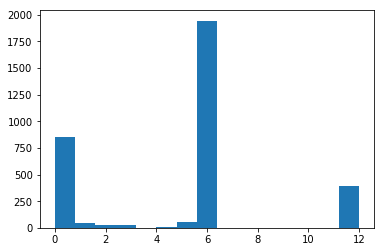

Taking action: [0, 'b', 'g']
Moving to state: 2
Reward from taking this action in previous state: (-1, False)


In [114]:
# Check that the tree runs simulations to choose the next action

print("INITIAL STATE: ")
print(str(s)+' '+game.StateNames[s]) # initial block game state


obs = []

action = agent.search(obs)
print("Taking action:", action)
state = game.next_state(s,action)
print("Moving to state:", state)

print("Reward from taking this action in previous state:",str(game.reward(s,action)))

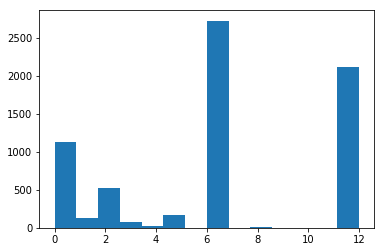

Taking action: [2, 'b', 'r']
Moving to state: 2


In [115]:
# take another action, this time a question, and see the observation 

obs = game.observation(state,action)
action = agent.search(obs)
print("Taking action:", action)
r = game.reward(state,action)
state = game.next_state(state,action)
print("Moving to state:", state)



INITIAL STATE: 5 b,rg
TARGET:  gbr
tree is none
Action 1: True state is 5, b,rg. Target is gbr.
Taking action Is r on b?.
observed  0
Reward so far:  -1
Action 2: True state is 5, b,rg. Target is gbr.
Taking action Put b on g..
Reward so far:  -6
Action 3: True state is 5, b,rg. Target is gbr.
Taking action Is g on b?.
observed  0
Reward so far:  -7
Action 4: True state is 5, b,rg. Target is gbr.
Taking action Is g on r?.
observed  0
Reward so far:  -8
Action 5: True state is 5, b,rg. Target is gbr.
Taking action Is b on g?.
observed  0
Reward so far:  -9
Action 6: True state is 5, b,rg. Target is gbr.
Taking action Take b off r..
Reward so far:  -14
Action 7: True state is 5, b,rg. Target is gbr.
Taking action Take r off g..
Reward so far:  -15
Action 8: True state is 0, r,g,b. Target is gbr.
Taking action Put b on r..
Reward so far:  -16
Action 9: True state is 4, g,br. Target is gbr.
Taking action Put g on b..
Reward so far:  -17
Action 10: True state is 10, gbr. Target is gbr.
Taki

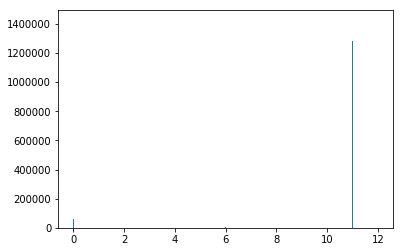

In [18]:
# if 'game' in locals():
#     del game
# if 'agent' in locals():
# #     del agent
del game
del agent

s = random.choice(range(0,6))
target = random.choice(range(7,12))

game = BlockGame(target)

c = 1

print("INITIAL STATE: "+str(s)+' '+game.StateNames[s]) # initial block game state
print("TARGET: "+' '+game.StateNames[target])

agent = POMCP(game, 0.9, c, maxdepth=30, nsims=5000)

action_seq = []
state = s
obs = []
R = 0


while len(action_seq) <= 30: # play for a certain amount of time (better rule?)

    action = agent.search(obs)
    action_seq.append(action)
    print('Action %i: True state is %s, %s. Target is %s.'% (len(action_seq), state, game.StateNames[state],game.StateNames[target]))
    print("Taking action %s"% act_str(action))
    
    obs = game.observation(state,action)
    if obs!=[]:
        print("observed ",obs)

    r,done = game.reward(state,action)
    if done:
        R=R+r
        break
    R = R + r
    print("Reward so far: ",R)    
    
    state = game.next_state(state,action)
    


print("game over!")
print('total reward: ', R)
plt.hist(agent.tree.children[0].belief,bins='auto')
plt.show()

In [117]:
for i in agent.tree.children[0].children:
    print("action: ",i.action)#agent.tree.children[0].children[i].action)
    print("value: ",i.value)#agent.tree.children[0].children[i].value)

action:  [0, 'r', 'g']
value:  -18.509999999999998
action:  [0, 'r', 'b']
value:  -12.181555555555555
action:  [0, 'g', 'r']
value:  -8.430154700000001
action:  [0, 'g', 'b']
value:  -13.093758999999999
action:  [0, 'b', 'r']
value:  -8.212991666666667
action:  [0, 'b', 'g']
value:  -7.884281875000001
action:  [1, 'r', 'g']
value:  -8.474060237500002
action:  [1, 'r', 'b']
value:  -16.318135714285717
action:  [1, 'g', 'r']
value:  -14.18714285714286
action:  [1, 'g', 'b']
value:  -13.841516666666667
action:  [1, 'b', 'r']
value:  -16.315616666666667
action:  [1, 'b', 'g']
value:  -7.419718714285715
action:  [2, 'r', 'g']
value:  -6.462506759668508
action:  [2, 'r', 'b']
value:  -6.626298446951221
action:  [2, 'g', 'r']
value:  -6.693985973841061
action:  [2, 'g', 'b']
value:  -6.461780753333333
action:  [2, 'b', 'r']
value:  -6.136080456771943
action:  [2, 'b', 'g']
value:  -6.509067239473683
action:  3
value:  -40.0
